***
# Model Deployment : Estimating Lung Cancer Probabilities From Demographic Factors And Behavioral Indicators

***
### John Pauline Pineda <br> <br> *August 17, 2024*
***

* [**1. Table of Contents**](#TOC)
    * [1.1 Data Background](#1.1)
    * [1.2 Data Description](#1.2)
    * [1.3 Data Quality Assessment](#1.3)
    * [1.4 Data Preprocessing](#1.4)
    * [1.5 Data Exploration](#1.5)
        * [1.5.1 Exploratory Data Analysis](#1.5.1)
        * [1.5.2 Hypothesis Testing](#1.5.2)
    * [1.6 Predictive Model Development](#1.6)
        * [1.6.1 Pre-Modelling Data Preparation](#1.6.1)
        * [1.6.2 Data Splitting](#1.6.2)
        * [1.6.3 Modelling Pipeline Development](#1.6.3)
            * [1.6.3.1 Individual Classifier](#1.6.3.1)
            * [1.6.3.2 Stacked Classifier](#1.6.3.2)
        * [1.6.4 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation](#1.6.4)
            * [1.6.4.1 Individual Classifier](#1.6.4.1)
            * [1.6.4.2 Stacked Classifier](#1.6.4.2)
        * [1.6.5 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation](#1.6.5)
            * [1.6.5.1 Individual Classifier](#1.6.5.1)
            * [1.6.5.2 Stacked Classifier](#1.6.5.2)
        * [1.6.6 Model Fitting using Downsampled Training Data | Hyperparameter Tuning | Validation](#1.6.6)
            * [1.6.6.1 Individual Classifier](#1.6.6.1)
            * [1.6.6.2 Stacked Classifier](#1.6.6.2)
        * [1.6.7 Model Selection](#1.6.7)
        * [1.6.8 Model Testing](#1.6.8)
        * [1.6.9 Model Inference | Interpretation](#1.6.9)
    * [1.7 Consolidated Findings](#1.7)
* [**2. Summary**](#Summary)   
* [**3. References**](#References)

***

# 1. Table of Contents <a class="anchor" id="TOC"></a>

## 1.1. Data Background <a class="anchor" id="1.1"></a>

## 1.2. Data Description <a class="anchor" id="1.2"></a>

In [1]:
##################################
# Loading Python Libraries
##################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
import joblib
%matplotlib inline
import shap

from operator import add,mul,truediv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy import stats
from scipy.stats import pointbiserialr

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
##################################
# Defining file paths
##################################
DATASETS_ORIGINAL_PATH = r"datasets\original"
DATASETS_PREPROCESSED_PATH = r"datasets\preprocessed"
DATASETS_FINAL_PATH = r"datasets\final\complete"
DATASETS_FINAL_TRAIN_PATH = r"datasets\final\train"
DATASETS_FINAL_TRAIN_FEATURES_PATH = r"datasets\final\train\features"
DATASETS_FINAL_TRAIN_TARGET_PATH = r"datasets\final\train\target"
DATASETS_FINAL_VALIDATION_PATH = r"datasets\final\validation"
DATASETS_FINAL_VALIDATION_FEATURES_PATH = r"datasets\final\validation\features"
DATASETS_FINAL_VALIDATION_TARGET_PATH = r"datasets\final\validation\target"
DATASETS_FINAL_TEST_PATH = r"datasets\final\test"
DATASETS_FINAL_TEST_FEATURES_PATH = r"datasets\final\test\features"
DATASETS_FINAL_TEST_TARGET_PATH = r"datasets\final\test\target"
MODELS_PATH = r"models"

In [3]:
##################################
# Loading the dataset
# from the DATASETS_ORIGINAL_PATH
##################################
lung_cancer = pd.read_csv(os.path.join("..", DATASETS_ORIGINAL_PATH, "lung_cancer.csv"))

In [4]:
##################################
# Performing a general exploration of the dataset
##################################
print('Dataset Dimensions: ')
display(lung_cancer.shape)

Dataset Dimensions: 


(309, 16)

In [5]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(lung_cancer.dtypes)

Column Names and Data Types:


GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

In [6]:
##################################
# Taking a snapshot of the dataset
##################################
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [7]:
##################################
# Setting the levels of the dichotomous categorical variables
# to boolean values
##################################
lung_cancer[['GENDER','LUNG_CANCER']] = lung_cancer[['GENDER','LUNG_CANCER']].astype('category')
lung_cancer['GENDER'] = lung_cancer['GENDER'].cat.set_categories(['F', 'M'], ordered=True)
lung_cancer['LUNG_CANCER'] = lung_cancer['LUNG_CANCER'].cat.set_categories(['NO', 'YES'], ordered=True)
lung_cancer.iloc[:,2:15] = lung_cancer.iloc[:,2:15].replace({1: 'Absent', 2: 'Present'})

In [8]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(lung_cancer.dtypes)

Column Names and Data Types:


GENDER                   category
AGE                         int64
SMOKING                    object
YELLOW_FINGERS             object
ANXIETY                    object
PEER_PRESSURE              object
CHRONIC DISEASE            object
FATIGUE                    object
ALLERGY                    object
WHEEZING                   object
ALCOHOL CONSUMING          object
COUGHING                   object
SHORTNESS OF BREATH        object
SWALLOWING DIFFICULTY      object
CHEST PAIN                 object
LUNG_CANCER              category
dtype: object

In [9]:
##################################
# Taking a snapshot of the dataset
##################################
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,Absent,Present,Present,Absent,Absent,Present,Absent,Present,Present,Present,Present,Present,Present,YES
1,M,74,Present,Absent,Absent,Absent,Present,Present,Present,Absent,Absent,Absent,Present,Present,Present,YES
2,F,59,Absent,Absent,Absent,Present,Absent,Present,Absent,Present,Absent,Present,Present,Absent,Present,NO
3,M,63,Present,Present,Present,Absent,Absent,Absent,Absent,Absent,Present,Absent,Absent,Present,Present,NO
4,F,63,Absent,Present,Absent,Absent,Absent,Absent,Absent,Present,Absent,Present,Present,Absent,Absent,NO


In [10]:
##################################
# Performing a general exploration 
# of the numeric variables
##################################
print('Numeric Variable Summary:')
display(lung_cancer.describe(include='number').transpose())

Numeric Variable Summary:


,count,mean,std,min,25%,50%,75%,max
AGE,309.0,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0


In [11]:
##################################
# Performing a general exploration 
# of the object and categorical variables
##################################
print('Categorical Variable Summary:')
display(lung_cancer.describe(include=['category','object']).transpose())

Categorical Variable Summary:


,count,unique,top,freq
GENDER,309,2,M,162
SMOKING,309,2,Present,174
YELLOW_FINGERS,309,2,Present,176
ANXIETY,309,2,Absent,155
PEER_PRESSURE,309,2,Present,155
CHRONIC DISEASE,309,2,Present,156
FATIGUE,309,2,Present,208
ALLERGY,309,2,Present,172
WHEEZING,309,2,Present,172
ALCOHOL CONSUMING,309,2,Present,172


## 1.3. Data Quality Assessment <a class="anchor" id="1.3"></a>

In [12]:
##################################
# Counting the number of duplicated rows
##################################
lung_cancer.duplicated().sum()

33

In [13]:
##################################
# Gathering the data types for each column
##################################
data_type_list = list(lung_cancer.dtypes)

In [14]:
##################################
# Gathering the variable names for each column
##################################
variable_name_list = list(lung_cancer.columns)

In [15]:
##################################
# Gathering the number of observations for each column
##################################
row_count_list = list([len(lung_cancer)] * len(lung_cancer.columns))

In [16]:
##################################
# Gathering the number of missing data for each column
##################################
null_count_list = list(lung_cancer.isna().sum(axis=0))

In [17]:
##################################
# Gathering the number of non-missing data for each column
##################################
non_null_count_list = list(lung_cancer.count())

In [18]:
##################################
# Gathering the missing data percentage for each column
##################################
fill_rate_list = map(truediv, non_null_count_list, row_count_list)

In [19]:
##################################
# Formulating the summary
# for all columns
##################################
all_column_quality_summary = pd.DataFrame(zip(variable_name_list,
                                              data_type_list,
                                              row_count_list,
                                              non_null_count_list,
                                              null_count_list,
                                              fill_rate_list), 
                                        columns=['Column.Name',
                                                 'Column.Type',
                                                 'Row.Count',
                                                 'Non.Null.Count',
                                                 'Null.Count',                                                 
                                                 'Fill.Rate'])
display(all_column_quality_summary)

,Column.Name,Column.Type,Row.Count,Non.Null.Count,Null.Count,Fill.Rate
0,GENDER,category,309,309,0,1.0
1,AGE,int64,309,309,0,1.0
2,SMOKING,object,309,309,0,1.0
3,YELLOW_FINGERS,object,309,309,0,1.0
4,ANXIETY,object,309,309,0,1.0
5,PEER_PRESSURE,object,309,309,0,1.0
6,CHRONIC DISEASE,object,309,309,0,1.0
7,FATIGUE,object,309,309,0,1.0
8,ALLERGY,object,309,309,0,1.0
9,WHEEZING,object,309,309,0,1.0


In [20]:
##################################
# Counting the number of columns
# with Fill.Rate < 1.00
##################################
print('Number of Columns with Missing Data:', str(len(all_column_quality_summary[(all_column_quality_summary['Fill.Rate']<1)])))

Number of Columns with Missing Data: 0


In [21]:
##################################
# Identifying the rows
# with Fill.Rate < 1.00
##################################
column_low_fill_rate = all_column_quality_summary[(all_column_quality_summary['Fill.Rate']<1.00)]

In [22]:
##################################
# Gathering the metadata labels for each observation
##################################
row_metadata_list = lung_cancer.index.values.tolist()

In [23]:
##################################
# Gathering the number of columns for each observation
##################################
column_count_list = list([len(lung_cancer.columns)] * len(lung_cancer))

In [24]:
##################################
# Gathering the number of missing data for each row
##################################
null_row_list = list(lung_cancer.isna().sum(axis=1))

In [25]:
##################################
# Gathering the missing data percentage for each column
##################################
missing_rate_list = map(truediv, null_row_list, column_count_list)

In [26]:
##################################
# Exploring the rows
# for missing data
##################################
all_row_quality_summary = pd.DataFrame(zip(row_metadata_list,
                                           column_count_list,
                                           null_row_list,
                                           missing_rate_list), 
                                        columns=['Row.Name',
                                                 'Column.Count',
                                                 'Null.Count',                                                 
                                                 'Missing.Rate'])
display(all_row_quality_summary)

,Row.Name,Column.Count,Null.Count,Missing.Rate
0,0,16,0,0.0
1,1,16,0,0.0
2,2,16,0,0.0
3,3,16,0,0.0
4,4,16,0,0.0
...,...,...,...,...
304,304,16,0,0.0
305,305,16,0,0.0
306,306,16,0,0.0
307,307,16,0,0.0


In [27]:
##################################
# Counting the number of rows
# with Fill.Rate < 1.00
##################################
print('Number of Rows with Missing Data:',str(len(all_row_quality_summary[all_row_quality_summary['Missing.Rate']>0])))

Number of Rows with Missing Data: 0


In [28]:
##################################
# Formulating the dataset
# with numeric columns only
##################################
lung_cancer_numeric = lung_cancer.select_dtypes(include=['number','int'])

In [29]:
##################################
# Gathering the variable names for each numeric column
##################################
numeric_variable_name_list = lung_cancer_numeric.columns

In [30]:
##################################
# Gathering the minimum value for each numeric column
##################################
numeric_minimum_list = lung_cancer_numeric.min()

In [31]:
##################################
# Gathering the mean value for each numeric column
##################################
numeric_mean_list = lung_cancer_numeric.mean()

In [32]:
##################################
# Gathering the median value for each numeric column
##################################
numeric_median_list = lung_cancer_numeric.median()

In [33]:
##################################
# Gathering the maximum value for each numeric column
##################################
numeric_maximum_list = lung_cancer_numeric.max()

In [34]:
##################################
# Gathering the first mode values for each numeric column
##################################
numeric_first_mode_list = [lung_cancer[x].value_counts(dropna=True).index.tolist()[0] for x in lung_cancer_numeric]

In [35]:
##################################
# Gathering the second mode values for each numeric column
##################################
numeric_second_mode_list = [lung_cancer[x].value_counts(dropna=True).index.tolist()[1] for x in lung_cancer_numeric]

In [36]:
##################################
# Gathering the count of first mode values for each numeric column
##################################
numeric_first_mode_count_list = [lung_cancer_numeric[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[0]]).sum() for x in lung_cancer_numeric]

In [37]:
##################################
# Gathering the count of second mode values for each numeric column
##################################
numeric_second_mode_count_list = [lung_cancer_numeric[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[1]]).sum() for x in lung_cancer_numeric]

In [38]:
##################################
# Gathering the first mode to second mode ratio for each numeric column
##################################
numeric_first_second_mode_ratio_list = map(truediv, numeric_first_mode_count_list, numeric_second_mode_count_list)

In [39]:
##################################
# Gathering the count of unique values for each numeric column
##################################
numeric_unique_count_list = lung_cancer_numeric.nunique(dropna=True)

In [40]:
##################################
# Gathering the number of observations for each numeric column
##################################
numeric_row_count_list = list([len(lung_cancer_numeric)] * len(lung_cancer_numeric.columns))

In [41]:
##################################
# Gathering the unique to count ratio for each numeric column
##################################
numeric_unique_count_ratio_list = map(truediv, numeric_unique_count_list, numeric_row_count_list)

In [42]:
##################################
# Gathering the skewness value for each numeric column
##################################
numeric_skewness_list = lung_cancer_numeric.skew()

In [43]:
##################################
# Gathering the kurtosis value for each numeric column
##################################
numeric_kurtosis_list = lung_cancer_numeric.kurtosis()

In [44]:
numeric_column_quality_summary = pd.DataFrame(zip(numeric_variable_name_list,
                                                numeric_minimum_list,
                                                numeric_mean_list,
                                                numeric_median_list,
                                                numeric_maximum_list,
                                                numeric_first_mode_list,
                                                numeric_second_mode_list,
                                                numeric_first_mode_count_list,
                                                numeric_second_mode_count_list,
                                                numeric_first_second_mode_ratio_list,
                                                numeric_unique_count_list,
                                                numeric_row_count_list,
                                                numeric_unique_count_ratio_list,
                                                numeric_skewness_list,
                                                numeric_kurtosis_list), 
                                        columns=['Numeric.Column.Name',
                                                 'Minimum',
                                                 'Mean',
                                                 'Median',
                                                 'Maximum',
                                                 'First.Mode',
                                                 'Second.Mode',
                                                 'First.Mode.Count',
                                                 'Second.Mode.Count',
                                                 'First.Second.Mode.Ratio',
                                                 'Unique.Count',
                                                 'Row.Count',
                                                 'Unique.Count.Ratio',
                                                 'Skewness',
                                                 'Kurtosis'])
display(numeric_column_quality_summary)

,Numeric.Column.Name,Minimum,Mean,Median,Maximum,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio,Skewness,Kurtosis
0,AGE,21,62.673139,62.0,87,64,63,20,19,1.052632,39,309,0.126214,-0.395086,1.746558


In [45]:
##################################
# Counting the number of numeric columns
# with First.Second.Mode.Ratio > 5.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['First.Second.Mode.Ratio']>5)])

0

In [46]:
##################################
# Counting the number of numeric columns
# with Unique.Count.Ratio > 10.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['Unique.Count.Ratio']>10)])

0

In [47]:
##################################
# Counting the number of numeric columns
# with Skewness > 3.00 or Skewness < -3.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['Skewness']>3) | (numeric_column_quality_summary['Skewness']<(-3))])

0

In [48]:
##################################
# Formulating the dataset
# with object or categorical column only
##################################
lung_cancer_object = lung_cancer.select_dtypes(include=['object','category'])

In [49]:
##################################
# Gathering the variable names for the object or categorical column
##################################
categorical_variable_name_list = lung_cancer_object.columns

In [50]:
##################################
# Gathering the first mode values for the object or categorical column
##################################
categorical_first_mode_list = [lung_cancer[x].value_counts().index.tolist()[0] for x in lung_cancer_object]

In [51]:
##################################
# Gathering the second mode values for each object or categorical column
##################################
categorical_second_mode_list = [lung_cancer[x].value_counts().index.tolist()[1] for x in lung_cancer_object]

In [52]:
##################################
# Gathering the count of first mode values for each object or categorical column
##################################
categorical_first_mode_count_list = [lung_cancer_object[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[0]]).sum() for x in lung_cancer_object]

In [53]:
##################################
# Gathering the count of second mode values for each object or categorical column
##################################
categorical_second_mode_count_list = [lung_cancer_object[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[1]]).sum() for x in lung_cancer_object]

In [54]:
##################################
# Gathering the first mode to second mode ratio for each object or categorical column
##################################
categorical_first_second_mode_ratio_list = map(truediv, categorical_first_mode_count_list, categorical_second_mode_count_list)

In [55]:
##################################
# Gathering the count of unique values for each object or categorical column
##################################
categorical_unique_count_list = lung_cancer_object.nunique(dropna=True)

In [56]:
##################################
# Gathering the number of observations for each object or categorical column
##################################
categorical_row_count_list = list([len(lung_cancer_object)] * len(lung_cancer_object.columns))

In [57]:
##################################
# Gathering the unique to count ratio for each object or categorical column
##################################
categorical_unique_count_ratio_list = map(truediv, categorical_unique_count_list, categorical_row_count_list)

In [58]:
categorical_column_quality_summary = pd.DataFrame(zip(categorical_variable_name_list,
                                                 categorical_first_mode_list,
                                                 categorical_second_mode_list,
                                                 categorical_first_mode_count_list,
                                                 categorical_second_mode_count_list,
                                                 categorical_first_second_mode_ratio_list,
                                                 categorical_unique_count_list,
                                                 categorical_row_count_list,
                                                 categorical_unique_count_ratio_list), 
                                        columns=['Categorical.Column.Name',
                                                 'First.Mode',
                                                 'Second.Mode',
                                                 'First.Mode.Count',
                                                 'Second.Mode.Count',
                                                 'First.Second.Mode.Ratio',
                                                 'Unique.Count',
                                                 'Row.Count',
                                                 'Unique.Count.Ratio'])
display(categorical_column_quality_summary)

,Categorical.Column.Name,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio
0,GENDER,M,F,162,147,1.102041,2,309,0.006472
1,SMOKING,Present,Absent,174,135,1.288889,2,309,0.006472
2,YELLOW_FINGERS,Present,Absent,176,133,1.323308,2,309,0.006472
3,ANXIETY,Absent,Present,155,154,1.006494,2,309,0.006472
4,PEER_PRESSURE,Present,Absent,155,154,1.006494,2,309,0.006472
5,CHRONIC DISEASE,Present,Absent,156,153,1.019608,2,309,0.006472
6,FATIGUE,Present,Absent,208,101,2.059406,2,309,0.006472
7,ALLERGY,Present,Absent,172,137,1.255474,2,309,0.006472
8,WHEEZING,Present,Absent,172,137,1.255474,2,309,0.006472
9,ALCOHOL CONSUMING,Present,Absent,172,137,1.255474,2,309,0.006472


In [59]:
##################################
# Counting the number of object or categorical columns
# with First.Second.Mode.Ratio > 5.00
##################################
len(categorical_column_quality_summary[(categorical_column_quality_summary['First.Second.Mode.Ratio']>5)])

1

In [60]:
##################################
# Identifying the object or categorical columns
# with First.Second.Mode.Ratio > 5.00
##################################
display(categorical_column_quality_summary[(categorical_column_quality_summary['First.Second.Mode.Ratio']>5)].sort_values(by=['First.Second.Mode.Ratio'], ascending=False))

,Categorical.Column.Name,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio
14,LUNG_CANCER,YES,NO,270,39,6.923077,2,309,0.006472


In [61]:
##################################
# Counting the number of object or categorical columns
# with Unique.Count.Ratio > 10.00
##################################
len(categorical_column_quality_summary[(categorical_column_quality_summary['Unique.Count.Ratio']>10)])

0

## 1.4. Data Preprocessing <a class="anchor" id="1.4"></a>

In [62]:
##################################
# Formulating the dataset
# with numeric columns only
##################################
lung_cancer_numeric = lung_cancer.select_dtypes(include=['number','int'])

In [63]:
##################################
# Gathering the variable names for each numeric column
##################################
numeric_variable_name_list = lung_cancer_numeric.columns

In [64]:
##################################
# Gathering the skewness value for each numeric column
##################################
numeric_skewness_list = lung_cancer_numeric.skew()

In [65]:
##################################
# Computing the interquartile range
# for all columns
##################################
lung_cancer_numeric_q1 = lung_cancer_numeric.quantile(0.25)
lung_cancer_numeric_q3 = lung_cancer_numeric.quantile(0.75)
lung_cancer_numeric_iqr = lung_cancer_numeric_q3 - lung_cancer_numeric_q1

In [66]:
##################################
# Gathering the outlier count for each numeric column
# based on the interquartile range criterion
##################################
numeric_outlier_count_list = ((lung_cancer_numeric < (lung_cancer_numeric_q1 - 1.5 * lung_cancer_numeric_iqr)) | (lung_cancer_numeric > (lung_cancer_numeric_q3 + 1.5 * lung_cancer_numeric_iqr))).sum()

In [67]:
##################################
# Gathering the number of observations for each column
##################################
numeric_row_count_list = list([len(lung_cancer_numeric)] * len(lung_cancer_numeric.columns))

In [68]:
##################################
# Gathering the unique to count ratio for each categorical column
##################################
numeric_outlier_ratio_list = map(truediv, numeric_outlier_count_list, numeric_row_count_list)

In [69]:
##################################
# Formulating the outlier summary
# for all numeric columns
##################################
numeric_column_outlier_summary = pd.DataFrame(zip(numeric_variable_name_list,
                                                  numeric_skewness_list,
                                                  numeric_outlier_count_list,
                                                  numeric_row_count_list,
                                                  numeric_outlier_ratio_list), 
                                        columns=['Numeric.Column.Name',
                                                 'Skewness',
                                                 'Outlier.Count',
                                                 'Row.Count',
                                                 'Outlier.Ratio'])
display(numeric_column_outlier_summary)

,Numeric.Column.Name,Skewness,Outlier.Count,Row.Count,Outlier.Ratio
0,AGE,-0.395086,2,309,0.006472


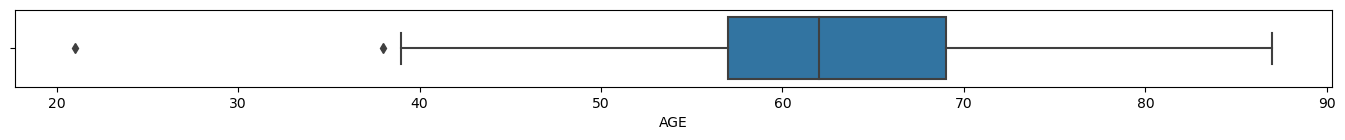

In [70]:
##################################
# Formulating the individual boxplots
# for all numeric columns
##################################
for column in lung_cancer_numeric:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=lung_cancer_numeric, x=column)

In [71]:
##################################
# Creating a dataset copy and
# converting all values to numeric
# for correlation analysis
##################################
lung_cancer_correlation = lung_cancer.copy()
lung_cancer_correlation_object = lung_cancer_correlation.iloc[:,2:15].columns
lung_cancer_correlation[lung_cancer_correlation_object] = lung_cancer_correlation[lung_cancer_correlation_object].replace({'Absent': 0, 'Present': 1})
lung_cancer_correlation = lung_cancer_correlation.drop(['GENDER','LUNG_CANCER'], axis=1)
display(lung_cancer_correlation)

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,69,0,1,1,0,0,1,0,1,1,1,1,1,1
1,74,1,0,0,0,1,1,1,0,0,0,1,1,1
2,59,0,0,0,1,0,1,0,1,0,1,1,0,1
3,63,1,1,1,0,0,0,0,0,1,0,0,1,1
4,63,0,1,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,56,0,0,0,1,1,1,0,0,1,1,1,1,0
305,70,1,0,0,0,0,1,1,1,1,1,1,0,1
306,58,1,0,0,0,0,0,1,1,1,1,0,0,1
307,67,1,0,1,0,0,1,1,0,1,1,1,0,1


In [72]:
##################################
# Initializing the correlation matrix
##################################
lung_cancer_correlation_matrix = pd.DataFrame(np.zeros((len(lung_cancer_correlation.columns), len(lung_cancer_correlation.columns))),
                                              columns=lung_cancer_correlation.columns,
                                              index=lung_cancer_correlation.columns)

In [73]:
##################################
# Calculating different types
# of correlation coefficients
# per variable type
##################################
for i in range(len(lung_cancer_correlation.columns)):
    for j in range(i, len(lung_cancer_correlation.columns)):
        if i == j:
            lung_cancer_correlation_matrix.iloc[i, j] = 1.0
        else:
            if lung_cancer_correlation.dtypes[i] == 'int64' and lung_cancer_correlation.dtypes[j] == 'int64':
                # Pearson correlation for two continuous variables
                corr = lung_cancer_correlation.iloc[:, i].corr(lung_cancer_correlation.iloc[:, j])
            elif lung_cancer_correlation.dtypes[i] == 'int64' or lung_cancer_correlation.dtypes[j] == 'int64':
                # Point-biserial correlation for one continuous and one binary variable
                continuous_var = lung_cancer_correlation.iloc[:, i] if lung_cancer_correlation.dtypes[i] == 'int64' else lung_cancer_correlation.iloc[:, j]
                binary_var = lung_cancer_correlation.iloc[:, j] if lung_cancer_correlation.dtypes[j] == 'int64' else lung_cancer_correlation.iloc[:, i]
                corr, _ = pointbiserialr(continuous_var, binary_var)
            else:
                # Phi coefficient for two binary variables
                corr = lung_cancer_correlation.iloc[:, i].corr(lung_cancer_correlation.iloc[:, j])
            lung_cancer_correlation_matrix.iloc[i, j] = corr
            lung_cancer_correlation_matrix.iloc[j, i] = corr

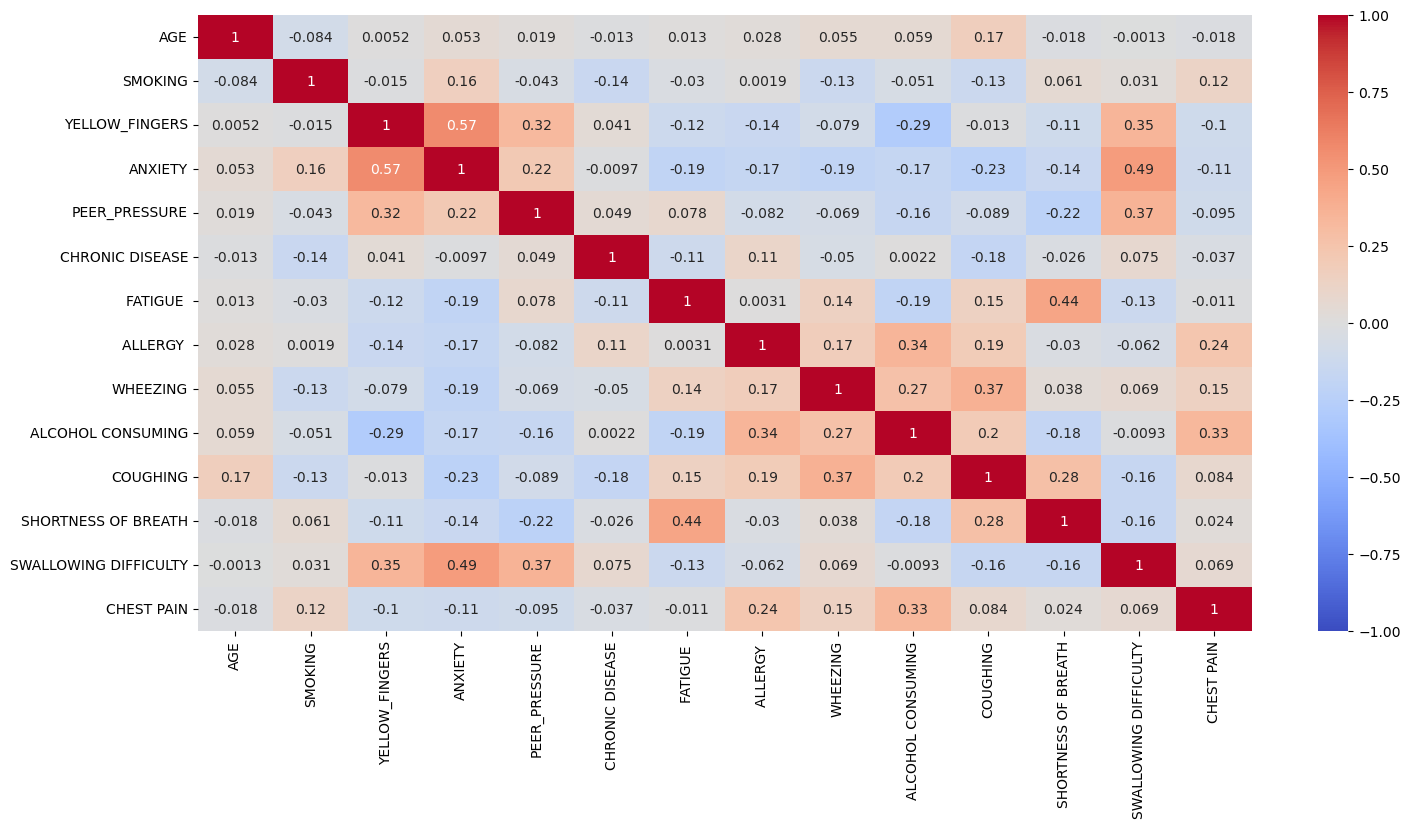

In [74]:
##################################
# Plotting the correlation matrix
# for all pairwise combinations
# of numeric and categorical columns
##################################
plt.figure(figsize=(17, 8))
sns.heatmap(lung_cancer_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## 1.5. Data Exploration <a class="anchor" id="1.5"></a>

### 1.5.1 Exploratory Data Analysis <a class="anchor" id="1.5.1"></a>

In [75]:
##################################
# Segregating the target
# and predictor variables
##################################
lung_cancer_predictors = lung_cancer.iloc[:,:-1].columns
lung_cancer_predictors_numeric = lung_cancer.iloc[:,:-1].loc[:,lung_cancer.iloc[:,:-1].columns == 'AGE'].columns
lung_cancer_predictors_categorical = lung_cancer.iloc[:,:-1].loc[:,lung_cancer.iloc[:,:-1].columns != 'AGE'].columns

In [76]:
##################################
# Segregating the target variable
# and numeric predictors
##################################
boxplot_y_variable = 'LUNG_CANCER'
boxplot_x_variable = lung_cancer_predictors_numeric.values[0]

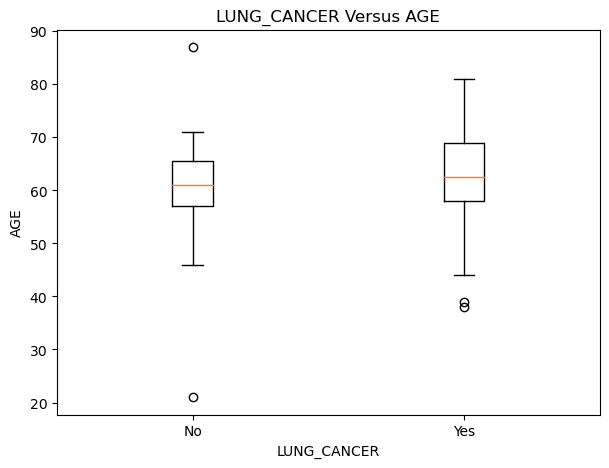

In [77]:
##################################
# Evaluating the numeric predictors
# against the target variable
##################################
plt.figure(figsize=(7, 5))
plt.boxplot([group[boxplot_x_variable] for name, group in lung_cancer.groupby(boxplot_y_variable)])
plt.title(f'{boxplot_y_variable} Versus {boxplot_x_variable}')
plt.xlabel(boxplot_y_variable)
plt.ylabel(boxplot_x_variable)
plt.xticks(range(1, len(lung_cancer[boxplot_y_variable].unique()) + 1), ['No', 'Yes'])
plt.show()

In [78]:
##################################
# Segregating the target variable
# and categorical predictors
##################################
proportion_y_variables = lung_cancer_predictors_categorical
proportion_x_variable = 'LUNG_CANCER'

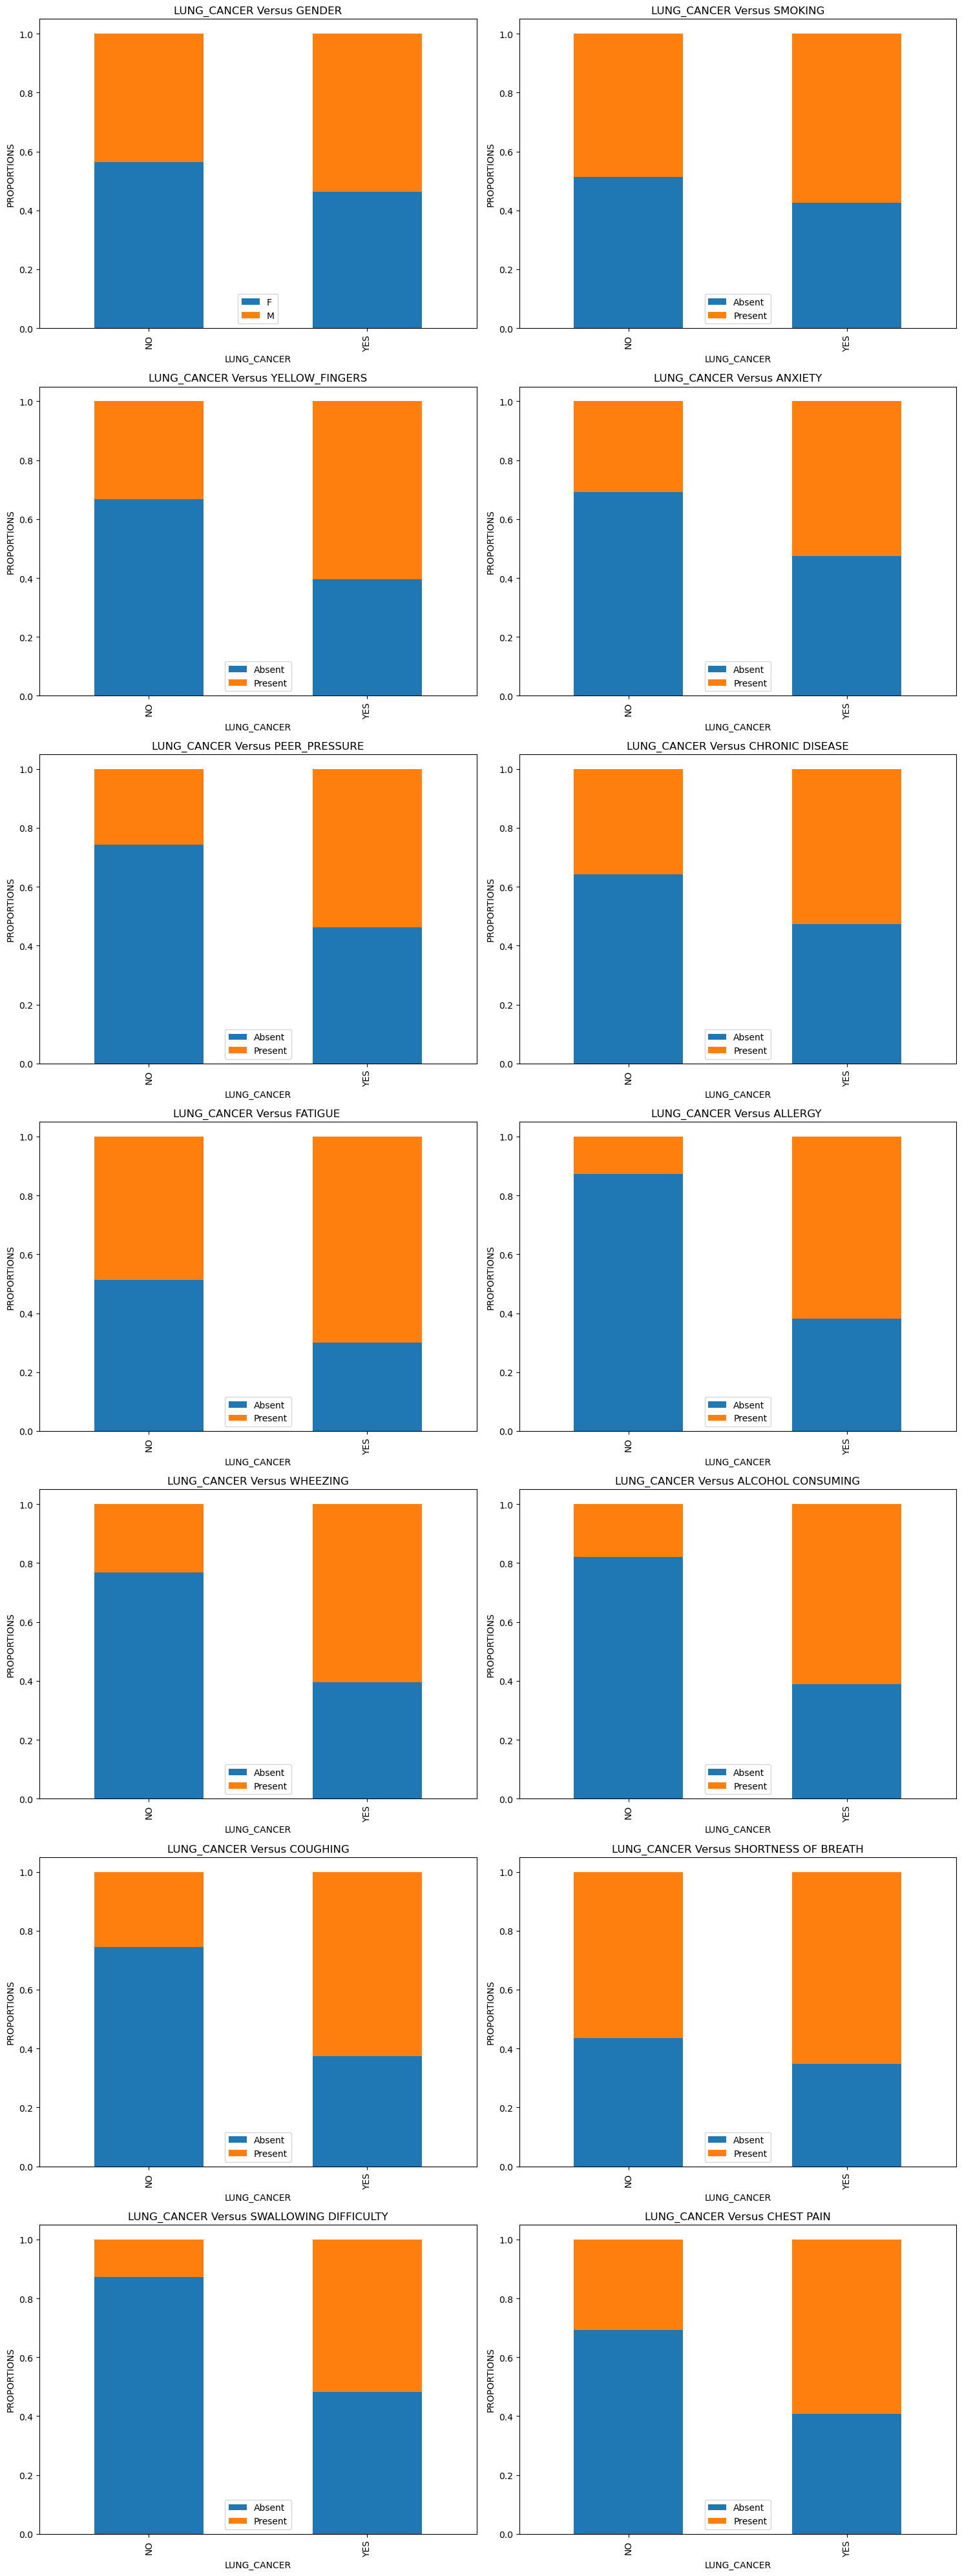

In [79]:
##################################
# Defining the number of 
# rows and columns for the subplots
##################################
num_rows = 7
num_cols = 2

##################################
# Formulating the subplot structure
##################################
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 40))

##################################
# Flattening the multi-row and
# multi-column axes
##################################
axes = axes.ravel()

##################################
# Formulating the individual stacked column plots
# for all categorical columns
##################################
for i, y_variable in enumerate(proportion_y_variables):
    ax = axes[i]
    category_counts = lung_cancer.groupby([proportion_x_variable, y_variable]).size().unstack(fill_value=0)
    category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)
    category_proportions.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'{proportion_x_variable} Versus {y_variable}')
    ax.set_xlabel(proportion_x_variable)
    ax.set_ylabel('PROPORTIONS')
    ax.legend(loc="lower center")

##################################
# Adjusting the subplot layout
##################################
plt.tight_layout()

##################################
# Presenting the subplots
##################################
plt.show()

### 1.5.2 Exploratory Data Analysis <a class="anchor" id="1.5.2"></a>

In [80]:
##################################
# Computing the t-test 
# statistic and p-values
# between the target variable
# and numeric predictor columns
##################################
lung_cancer_numeric_ttest_target = {}
lung_cancer_numeric = lung_cancer.loc[:,(lung_cancer.columns == 'AGE') | (lung_cancer.columns == 'LUNG_CANCER')]
lung_cancer_numeric_columns = lung_cancer_predictors_numeric
for numeric_column in lung_cancer_numeric_columns:
    group_0 = lung_cancer_numeric[lung_cancer_numeric.loc[:,'LUNG_CANCER']=='NO']
    group_1 = lung_cancer_numeric[lung_cancer_numeric.loc[:,'LUNG_CANCER']=='YES']
    lung_cancer_numeric_ttest_target['LUNG_CANCER_' + numeric_column] = stats.ttest_ind(
        group_0[numeric_column], 
        group_1[numeric_column], 
        equal_var=True)

In [81]:
##################################
# Formulating the pairwise ttest summary
# between the target variable
# and numeric predictor columns
##################################
lung_cancer_numeric_summary = lung_cancer_numeric.from_dict(lung_cancer_numeric_ttest_target, orient='index')
lung_cancer_numeric_summary.columns = ['T.Test.Statistic', 'T.Test.PValue']
display(lung_cancer_numeric_summary.sort_values(by=['T.Test.PValue'], ascending=True).head(len(lung_cancer_predictors_numeric)))

,T.Test.Statistic,T.Test.PValue
LUNG_CANCER_AGE,-1.573857,0.11655


In [82]:
lung_cancer_predictors_categorical

Index(['GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
       'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN'],
      dtype='object')

In [83]:
##################################
# Computing the chisquare
# statistic and p-values
# between the target variable
# and categorical predictor columns
##################################
lung_cancer_categorical_chisquare_target = {}
lung_cancer_categorical = lung_cancer.loc[:,(lung_cancer.columns != 'AGE') | (lung_cancer.columns == 'LUNG_CANCER')]
lung_cancer_categorical_columns = lung_cancer_predictors_categorical
for categorical_column in lung_cancer_categorical_columns:
    contingency_table = pd.crosstab(lung_cancer_categorical[categorical_column], 
                                    lung_cancer_categorical['LUNG_CANCER'])
    lung_cancer_categorical_chisquare_target['LUNG_CANCER_' + categorical_column] = stats.chi2_contingency(
        contingency_table)[0:2]

In [84]:
##################################
# Formulating the pairwise chisquare summary
# between the target variable
# and categorical predictor columns
##################################
lung_cancer_categorical_summary = lung_cancer_categorical.from_dict(lung_cancer_categorical_chisquare_target, orient='index')
lung_cancer_categorical_summary.columns = ['ChiSquare.Test.Statistic', 'ChiSquare.Test.PValue']
display(lung_cancer_categorical_summary.sort_values(by=['ChiSquare.Test.PValue'], ascending=True).head(len(lung_cancer_predictors_categorical)))

,ChiSquare.Test.Statistic,ChiSquare.Test.PValue
LUNG_CANCER_ALLERGY,31.238952,2.281422e-08
LUNG_CANCER_ALCOHOL CONSUMING,24.005406,9.606559e-07
LUNG_CANCER_SWALLOWING DIFFICULTY,19.307277,1.112814e-05
LUNG_CANCER_WHEEZING,17.723096,2.555055e-05
LUNG_CANCER_COUGHING,17.606122,2.717123e-05
LUNG_CANCER_CHEST PAIN,10.083198,1.496275e-03
LUNG_CANCER_PEER_PRESSURE,9.641594,1.902201e-03
LUNG_CANCER_YELLOW_FINGERS,9.088186,2.572659e-03
LUNG_CANCER_FATIGUE,6.081100,1.366356e-02
LUNG_CANCER_ANXIETY,5.648390,1.747141e-02


## 1.6. Predictive Model Development <a class="anchor" id="1.6"></a>

### 1.6.1 Pre-Modelling Data Preparation <a class="anchor" id="1.6.1"></a>

In [85]:
##################################
# Creating a dataset copy and
# transforming all values to numeric
# prior to data splitting and modelling
##################################
lung_cancer_transformed = lung_cancer.copy()
lung_cancer_transformed_object = lung_cancer_transformed.iloc[:,2:15].columns
lung_cancer_transformed['GENDER'] = lung_cancer_transformed['GENDER'].replace({'F': 0, 'M': 1})
lung_cancer_transformed['LUNG_CANCER'] = lung_cancer_transformed['LUNG_CANCER'].replace({'NO': 0, 'YES': 1})
lung_cancer_transformed[lung_cancer_transformed_object] = lung_cancer_transformed[lung_cancer_transformed_object].replace({'Absent': 0, 'Present': 1})
display(lung_cancer_transformed)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,1,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,1,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,1,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


In [86]:
##################################
# Saving the tranformed data
# to the DATASETS_PREPROCESSED_PATH
##################################
lung_cancer_transformed.to_csv(os.path.join("..", DATASETS_PREPROCESSED_PATH, "lung_cancer_transformed.csv"), index=False)

In [87]:
##################################
# Filtering out predictors that did not exhibit 
# sufficient discrimination of the target variable
# Saving the tranformed data
# to the DATASETS_PREPROCESSED_PATH
##################################
lung_cancer_filtered = lung_cancer_transformed.drop(['GENDER','CHRONIC DISEASE', 'SHORTNESS OF BREATH', 'SMOKING', 'AGE'], axis=1)
lung_cancer_filtered.to_csv(os.path.join("..", DATASETS_FINAL_PATH, "lung_cancer_final.csv"), index=False)

### 1.6.2 Data Splitting <a class="anchor" id="1.6.2"></a>

In [88]:
##################################
# Creating a dataset copy
# of the filtered data
##################################
lung_cancer_final = lung_cancer_filtered.copy()

In [89]:
##################################
# Performing a general exploration
# of the final dataset
##################################
print('Final Dataset Dimensions: ')
display(lung_cancer_final.shape)

Final Dataset Dimensions: 


(309, 11)

In [90]:
print('Target Variable Breakdown: ')
lung_cancer_breakdown = lung_cancer_final.groupby('LUNG_CANCER').size().reset_index(name='Count')
lung_cancer_breakdown['Percentage'] = (lung_cancer_breakdown['Count'] / len(lung_cancer_final)) * 100
display(lung_cancer_breakdown)

Target Variable Breakdown: 


,LUNG_CANCER,Count,Percentage
0,0,39,12.621359
1,1,270,87.378641


In [91]:
##################################
# Formulating the train and test data
# from the final dataset
# by applying stratification and
# using a 70-30 ratio
##################################
lung_cancer_train_initial, lung_cancer_test = train_test_split(lung_cancer_final, 
                                                               test_size=0.20, 
                                                               stratify=lung_cancer_final['LUNG_CANCER'], 
                                                               random_state=88888888)

In [92]:
##################################
# Performing a general exploration
# of the initial training dataset
##################################
X_train_initial = lung_cancer_train_initial.drop('LUNG_CANCER', axis = 1)
y_train_initial = lung_cancer_train_initial['LUNG_CANCER']
print('Initial Training Dataset Dimensions: ')
display(X_train_initial.shape)
display(y_train_initial.shape)
print('Initial Training Target Variable Breakdown: ')
display(y_train_initial.value_counts(normalize = True))

Initial Training Dataset Dimensions: 


(247, 10)

(247,)

Initial Training Target Variable Breakdown: 


1    0.874494
0    0.125506
Name: LUNG_CANCER, dtype: float64

In [93]:
##################################
# Performing a general exploration
# of the test dataset
##################################
X_test = lung_cancer_test.drop('LUNG_CANCER', axis = 1)
y_test = lung_cancer_test['LUNG_CANCER']
print('Test Dataset Dimensions: ')
display(X_test.shape)
display(y_test.shape)
print('Test Target Variable Breakdown: ')
display(y_test.value_counts(normalize = True))

Test Dataset Dimensions: 


(62, 10)

(62,)

Test Target Variable Breakdown: 


1    0.870968
0    0.129032
Name: LUNG_CANCER, dtype: float64

In [94]:
##################################
# Formulating the train and validation data
# from the train dataset
# by applying stratification and
# using a 70-30 ratio
##################################
lung_cancer_train, lung_cancer_validation = train_test_split(lung_cancer_train_initial, 
                                                             test_size=0.20, 
                                                             stratify=lung_cancer_train_initial['LUNG_CANCER'], 
                                                             random_state=88888888)

In [95]:
##################################
# Performing a general exploration
# of the final training dataset
##################################
X_train = lung_cancer_train.drop('LUNG_CANCER', axis = 1)
y_train = lung_cancer_train['LUNG_CANCER']
print('Training Dataset Dimensions: ')
display(X_train.shape)
display(y_train.shape)
print('Training Target Variable Breakdown: ')
display(y_train.value_counts())
print('Training Target Variable Proportion: ')
display(y_train.value_counts(normalize = True))

Training Dataset Dimensions: 


(197, 10)

(197,)

Training Target Variable Breakdown: 


1    172
0     25
Name: LUNG_CANCER, dtype: int64

Training Target Variable Proportion: 


1    0.873096
0    0.126904
Name: LUNG_CANCER, dtype: float64

In [96]:
##################################
# Performing a general exploration
# of the validation dataset
##################################
X_validation = lung_cancer_validation.drop('LUNG_CANCER', axis = 1)
y_validation = lung_cancer_validation['LUNG_CANCER']
print('Validation Dataset Dimensions: ')
display(X_validation.shape)
display(y_validation.shape)
print('Validation Target Variable Breakdown: ')
display(y_validation.value_counts(normalize = True))

Validation Dataset Dimensions: 


(50, 10)

(50,)

Validation Target Variable Breakdown: 


1    0.88
0    0.12
Name: LUNG_CANCER, dtype: float64

In [97]:
##################################
# Saving the training data
# to the DATASETS_FINAL_TRAIN_PATH
# and DATASETS_FINAL_TRAIN_FEATURES_PATH
# and DATASETS_FINAL_TRAIN_TARGET_PATH
##################################
lung_cancer_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_PATH, "lung_cancer_train.csv"), index=False)
X_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_FEATURES_PATH, "X_train.csv"), index=False)
y_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_TARGET_PATH, "y_train.csv"), index=False)

In [98]:
##################################
# Saving the validation data
# to the DATASETS_FINAL_VALIDATION_PATH
# and DATASETS_FINAL_VALIDATION_FEATURE_PATH
# and DATASETS_FINAL_VALIDATION_TARGET_PATH
##################################
lung_cancer_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_PATH, "lung_cancer_validation.csv"), index=False)
X_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_FEATURES_PATH, "X_validation.csv"), index=False)
y_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_TARGET_PATH, "y_validation.csv"), index=False)

In [99]:
##################################
# Saving the test data
# to the DATASETS_FINAL_TEST_PATH
# and DATASETS_FINAL_TEST_FEATURES_PATH
# and DATASETS_FINAL_TEST_TARGET_PATH
##################################
lung_cancer_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_PATH, "lung_cancer_test.csv"), index=False)
X_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_FEATURES_PATH, "X_test.csv"), index=False)
y_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_TARGET_PATH, "y_test.csv"), index=False)

### 1.6.3 Modelling Pipeline Development <a class="anchor" id="1.6.3"></a>

#### 1.6.3.1 Individual Classifier <a class="anchor" id="1.6.3.1"></a>

In [100]:
##################################
# Defining the modelling pipeline
# using the logistic regression structure
##################################
individual_pipeline = Pipeline([('individual_model', LogisticRegression(solver='saga', 
                                                             random_state=88888888, 
                                                             max_iter=5000))])

In [101]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
individual_unbalanced_class_hyperparameter_grid = {'individual_model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                                                   'individual_model__l1_ratio': [0.25, 0.50, 0.75],
                                                   'individual_model__class_weight': ['balanced']}

In [102]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
individual_unbalanced_class_grid_search = GridSearchCV(estimator=individual_pipeline,
                                                       param_grid=individual_unbalanced_class_hyperparameter_grid,
                                                       scoring='f1',
                                                       cv=5, 
                                                       n_jobs=-1,
                                                       verbose=1)

In [103]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
individual_balanced_class_hyperparameter_grid = {'individual_model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                                                 'individual_model__l1_ratio': [0.25, 0.50, 0.75],
                                                 'individual_model__class_weight': ['none']}

In [104]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
individual_balanced_class_grid_search = GridSearchCV(estimator=individual_pipeline,
                                                     param_grid=individual_balanced_class_hyperparameter_grid,
                                                     scoring='f1',
                                                     cv=5, 
                                                     n_jobs=-1,
                                                     verbose=1)

#### 1.6.3.2 Stacked Classifier <a class="anchor" id="1.6.3.2"></a>

In [105]:
##################################
# Defining the base learners
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
##################################
stacked_unbalanced_class_base_learners = [('dt', DecisionTreeClassifier(class_weight='balanced',
                                                                         criterion='entropy',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('rf', RandomForestClassifier(class_weight='balanced',
                                                                         criterion='entropy',
                                                                         max_features='sqrt',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('svm', SVC(class_weight='balanced',
                                                       C=1.0,
                                                       random_state=88888888))]

In [106]:
##################################
# Defining the meta learner
# using the logistic regression structure
##################################
stacked_unbalanced_class_meta_learner = LogisticRegression(solver='saga', 
                                                           random_state=88888888,
                                                           max_iter=5000)

In [107]:
##################################
# Defining the stacking model
# using the logistic regression structure
##################################
stacked_unbalanced_class_model = StackingClassifier(estimators=stacked_unbalanced_class_base_learners,
                                                    final_estimator=stacked_unbalanced_class_meta_learner)

In [108]:
##################################
# Defining the modelling pipeline
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
# using the logistic regression structure
##################################
stacked_unbalanced_class_pipeline = Pipeline([('stacked_model', stacked_unbalanced_class_model)])

In [109]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
stacked_unbalanced_class_hyperparameter_grid = {'stacked_model__dt__max_depth': [3, 5],
                                                'stacked_model__rf__max_depth': [3, 5],
                                                'stacked_model__svm__kernel': ['linear', 'poly', 'rbf'],
                                                'stacked_model__final_estimator__penalty': ['l1', 'l2', 'elasticnet'],
                                                'stacked_model__final_estimator__l1_ratio': [0.25, 0.50, 0.75],
                                                'stacked_model__final_estimator__class_weight': ['balanced']}

In [110]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
stacked_unbalanced_class_grid_search = GridSearchCV(estimator=stacked_unbalanced_class_pipeline,
                                                    param_grid=stacked_unbalanced_class_hyperparameter_grid,
                                                    scoring='f1',
                                                    cv=5,
                                                    n_jobs=-1,
                                                    verbose=1)

### 1.6.4 Model Fitting using Original Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.4"></a>

#### 1.6.4.1 Individual Classifier <a class="anchor" id="1.6.4.1"></a>

In [111]:
##################################
# Fitting the model on the 
# original training data
##################################
individual_unbalanced_class_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('individual_model',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=88888888,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'individual_model__class_weight': ['balanced'],
                         'individual_model__l1_ratio': [0.25, 0.5, 0.75],
                         'individual_model__penalty': ['l1', 'l2', 'elasticnet',
                                                       'none']},
             scoring='f1', verbose=1)

In [112]:
##################################
# Identifying the best model
##################################
individual_unbalanced_class_best_model_original = individual_unbalanced_class_grid_search.best_estimator_

In [113]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
individual_unbalanced_class_best_model_original_f1_cv = individual_unbalanced_class_grid_search.best_score_
individual_unbalanced_class_best_model_original_f1_train = f1_score(y_train, individual_unbalanced_class_best_model_original.predict(X_train))
individual_unbalanced_class_best_model_original_f1_validation = f1_score(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation))

In [114]:
##################################
# Identifying the optimal model
##################################
print('Best Individual Model using the Original Train Data: ')
print(f"Best Individual Model Parameters: {individual_unbalanced_class_grid_search.best_params_}")

Best Individual Model using the Original Train Data: 
Best Individual Model Parameters: {'individual_model__class_weight': 'balanced', 'individual_model__l1_ratio': 0.25, 'individual_model__penalty': 'elasticnet'}


In [115]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {individual_unbalanced_class_best_model_original_f1_cv:.4f}")
print(f"F1 Score on Training Data: {individual_unbalanced_class_best_model_original_f1_train:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train, individual_unbalanced_class_best_model_original.predict(X_train)))

F1 Score on Cross-Validated Data: 0.9339
F1 Score on Training Data: 0.9455

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.59      0.92      0.72        25
           1       0.99      0.91      0.95       172

    accuracy                           0.91       197
   macro avg       0.79      0.91      0.83       197
weighted avg       0.94      0.91      0.92       197



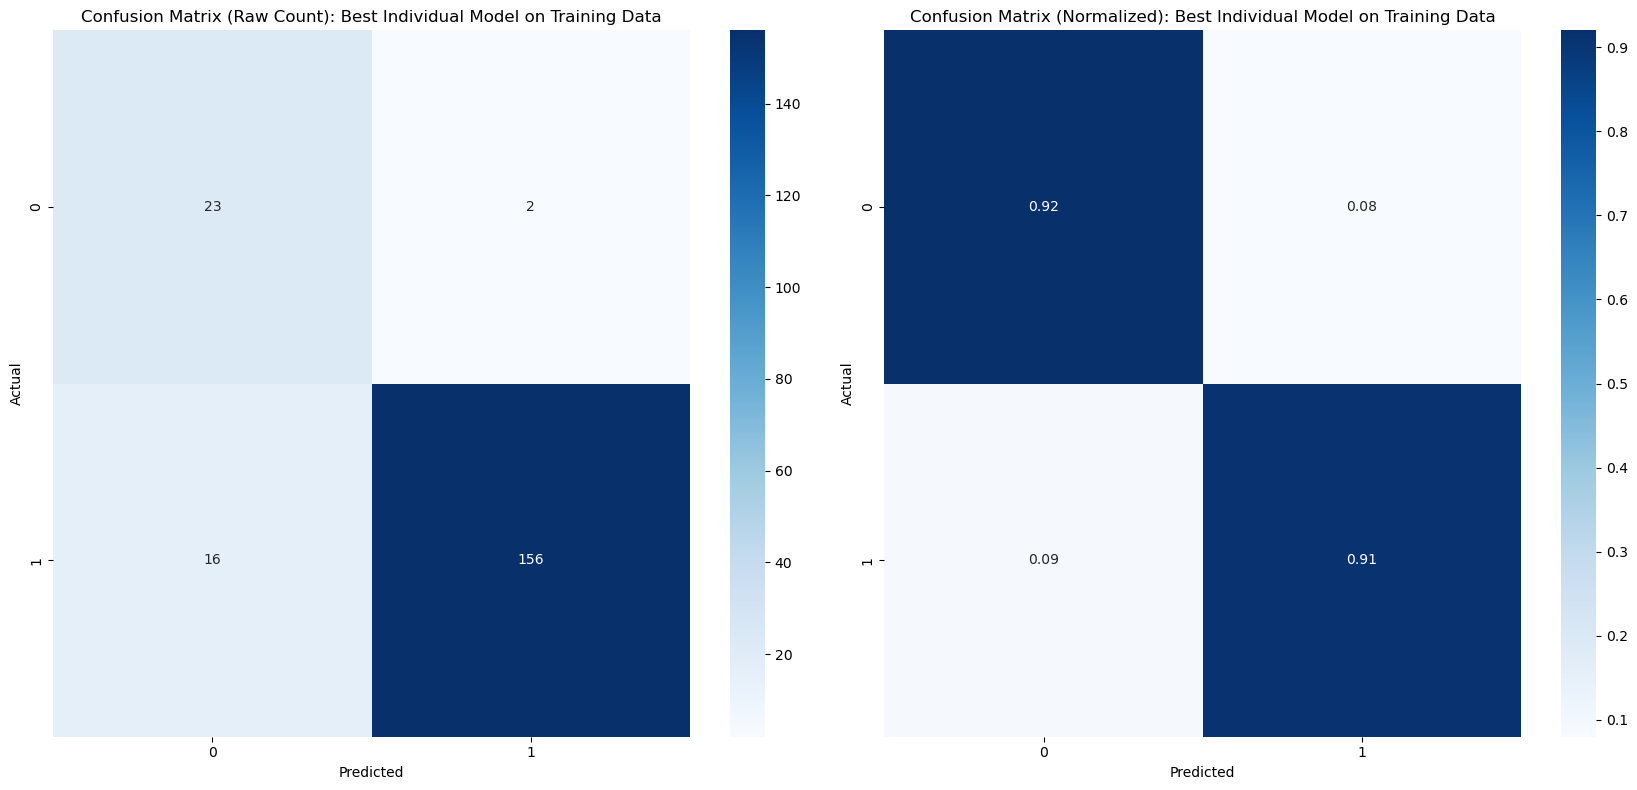

In [116]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train, individual_unbalanced_class_best_model_original.predict(X_train))
cm_normalized = confusion_matrix(y_train, individual_unbalanced_class_best_model_original.predict(X_train), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [117]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {individual_unbalanced_class_best_model_original_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation)))

F1 Score on Validation Data: 0.9176

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.95      0.89      0.92        44

    accuracy                           0.86        50
   macro avg       0.70      0.78      0.73        50
weighted avg       0.89      0.86      0.87        50



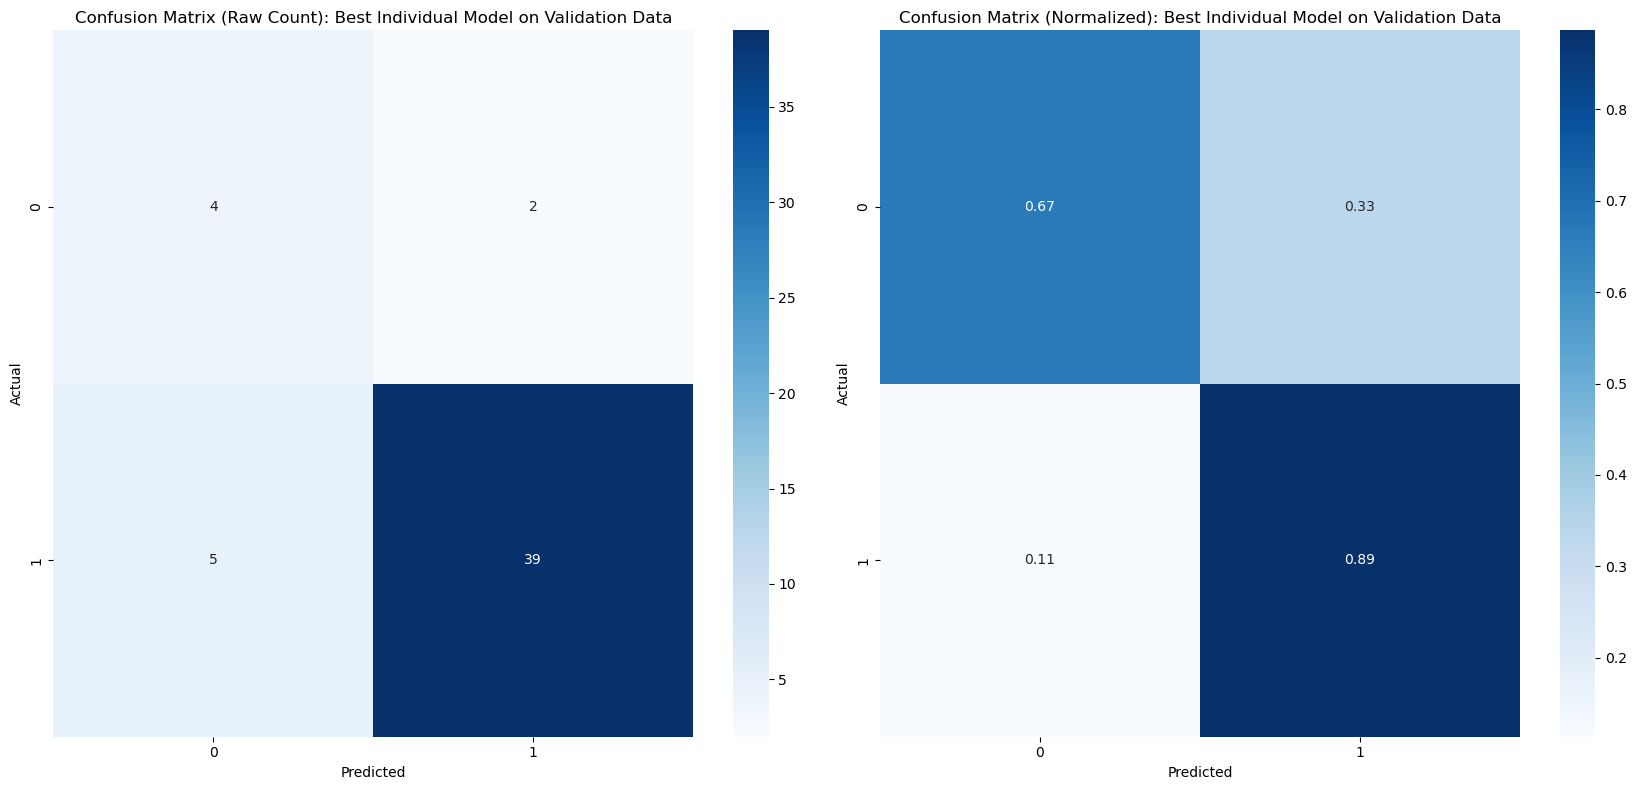

In [118]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [119]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
individual_unbalanced_class_best_model_original_logit_values = individual_unbalanced_class_best_model_original.decision_function(X_train)

In [120]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
individual_unbalanced_class_best_model_original_probabilities = individual_unbalanced_class_best_model_original.predict_proba(X_train)[:, 1]

In [121]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
individual_unbalanced_class_best_model_original_sorted_indices = np.argsort(individual_unbalanced_class_best_model_original_logit_values)
individual_unbalanced_class_best_model_original_logit_values_sorted = individual_unbalanced_class_best_model_original_logit_values[individual_unbalanced_class_best_model_original_sorted_indices]
individual_unbalanced_class_best_model_original_probabilities_sorted = individual_unbalanced_class_best_model_original_probabilities[individual_unbalanced_class_best_model_original_sorted_indices]

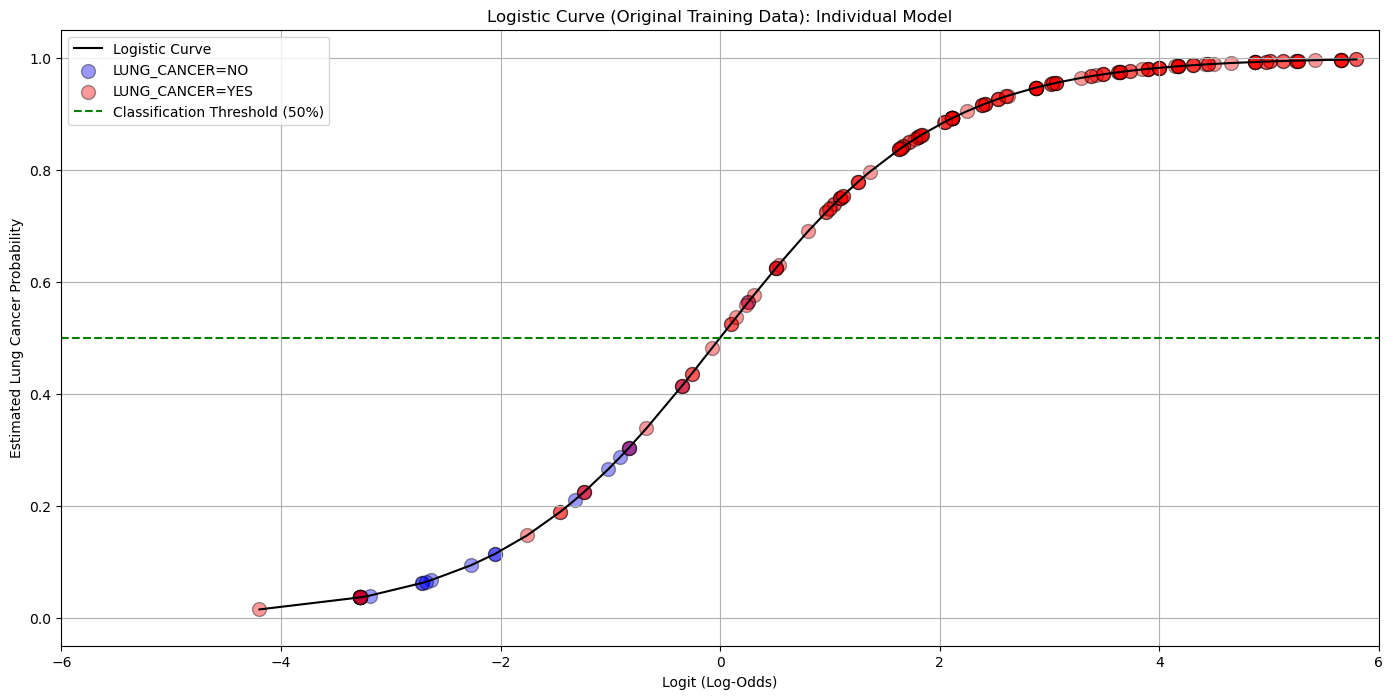

In [122]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(individual_unbalanced_class_best_model_original_logit_values_sorted, 
         individual_unbalanced_class_best_model_original_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-6.00, 6.00)
target_0_indices = y_train == 0
target_1_indices = y_train == 1
plt.scatter(individual_unbalanced_class_best_model_original_logit_values[target_0_indices], 
            individual_unbalanced_class_best_model_original_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(individual_unbalanced_class_best_model_original_logit_values[target_1_indices], 
            individual_unbalanced_class_best_model_original_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Original Training Data): Individual Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [123]:
##################################
# Saving the best individual model
# developed from the original training data
################################## 
joblib.dump(individual_unbalanced_class_best_model_original, 
            os.path.join("..", MODELS_PATH, "individual_unbalanced_class_best_model_original.pkl"))

['..\\models\\individual_unbalanced_class_best_model_original.pkl']

#### 1.6.4.2 Stacked Classifier <a class="anchor" id="1.6.4.2"></a>

In [124]:
##################################
# Fitting the model on the 
# original training data
##################################
stacked_unbalanced_class_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stacked_model',
                                        StackingClassifier(estimators=[('dt',
                                                                        DecisionTreeClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('rf',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('svm',
                                                                        SVC(class_weight='b...
             n_jobs=-1,
             param_grid={'stacked_model__dt__max_depth': [3, 5],
                         'stacked_model__final_estimator__class_weight': ['balanced'],
                         'stacked_model__final_estimator__l1_ratio': [0.25, 0.5,
                                                                      0.75],
                         'stacked_model__final_estimator__penalty': ['l1', 'l2',
                                                                     'elasticnet'],
                         'stacked_model__rf__max_depth': [3, 5],
                         'stacked_model__svm__kernel': ['linear', 'poly',
                                                        'rbf']},
             scoring='f1', verbose=1)

In [125]:
##################################
# Identifying the best model
##################################
stacked_unbalanced_class_best_model_original = stacked_unbalanced_class_grid_search.best_estimator_

In [126]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
stacked_unbalanced_class_best_model_original_f1_cv = stacked_unbalanced_class_grid_search.best_score_
stacked_unbalanced_class_best_model_original_f1_train = f1_score(y_train, stacked_unbalanced_class_best_model_original.predict(X_train))
stacked_unbalanced_class_best_model_original_f1_validation = f1_score(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation))

In [127]:
##################################
# Identifying the optimal model
##################################
print('Best Stacked Model using the Original Train Data: ')
print(f"Best Stacked Model Parameters: {stacked_unbalanced_class_grid_search.best_params_}")

Best Stacked Model using the Original Train Data: 
Best Stacked Model Parameters: {'stacked_model__dt__max_depth': 5, 'stacked_model__final_estimator__class_weight': 'balanced', 'stacked_model__final_estimator__l1_ratio': 0.25, 'stacked_model__final_estimator__penalty': 'l1', 'stacked_model__rf__max_depth': 3, 'stacked_model__svm__kernel': 'rbf'}


In [128]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {stacked_unbalanced_class_best_model_original_f1_cv:.4f}")
print(f"F1 Score on Training Data: {stacked_unbalanced_class_best_model_original_f1_train:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train, stacked_unbalanced_class_best_model_original.predict(X_train)))

F1 Score on Cross-Validated Data: 0.9245
F1 Score on Training Data: 0.9483

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.60      0.96      0.74        25
           1       0.99      0.91      0.95       172

    accuracy                           0.91       197
   macro avg       0.80      0.93      0.84       197
weighted avg       0.94      0.91      0.92       197



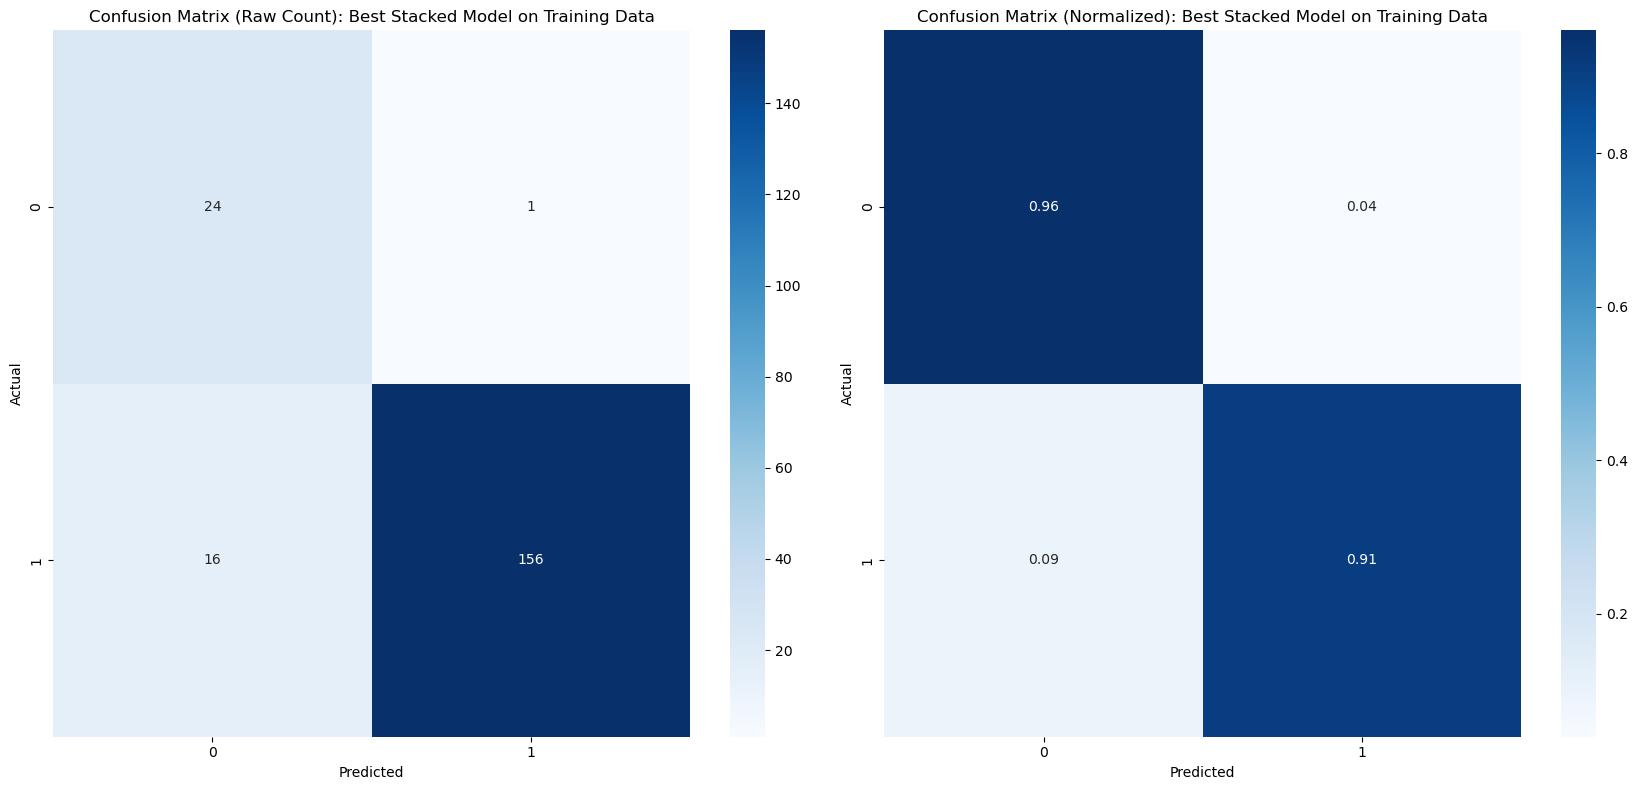

In [129]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train, stacked_unbalanced_class_best_model_original.predict(X_train))
cm_normalized = confusion_matrix(y_train, stacked_unbalanced_class_best_model_original.predict(X_train), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [130]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {stacked_unbalanced_class_best_model_original_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation)))

F1 Score on Validation Data: 0.8916

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.36      0.67      0.47         6
           1       0.95      0.84      0.89        44

    accuracy                           0.82        50
   macro avg       0.66      0.75      0.68        50
weighted avg       0.88      0.82      0.84        50



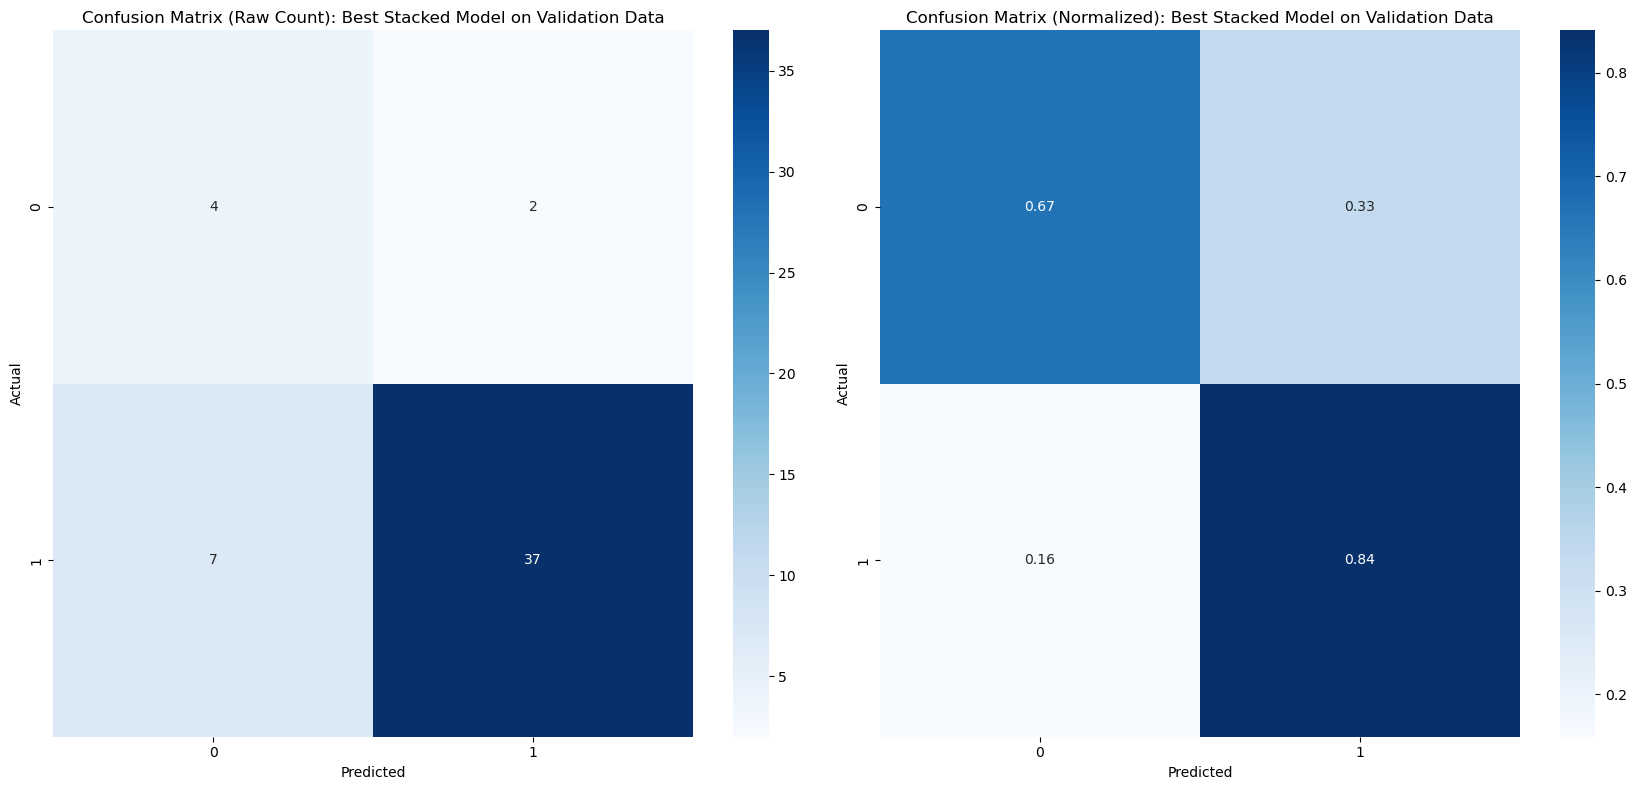

In [131]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [132]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
stacked_unbalanced_class_best_model_original_logit_values = stacked_unbalanced_class_best_model_original.decision_function(X_train)

In [133]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
stacked_unbalanced_class_best_model_original_probabilities = stacked_unbalanced_class_best_model_original.predict_proba(X_train)[:, 1]

In [134]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
stacked_unbalanced_class_best_model_original_sorted_indices = np.argsort(stacked_unbalanced_class_best_model_original_logit_values)
stacked_unbalanced_class_best_model_original_logit_values_sorted = stacked_unbalanced_class_best_model_original_logit_values[stacked_unbalanced_class_best_model_original_sorted_indices]
stacked_unbalanced_class_best_model_original_probabilities_sorted = stacked_unbalanced_class_best_model_original_probabilities[stacked_unbalanced_class_best_model_original_sorted_indices]

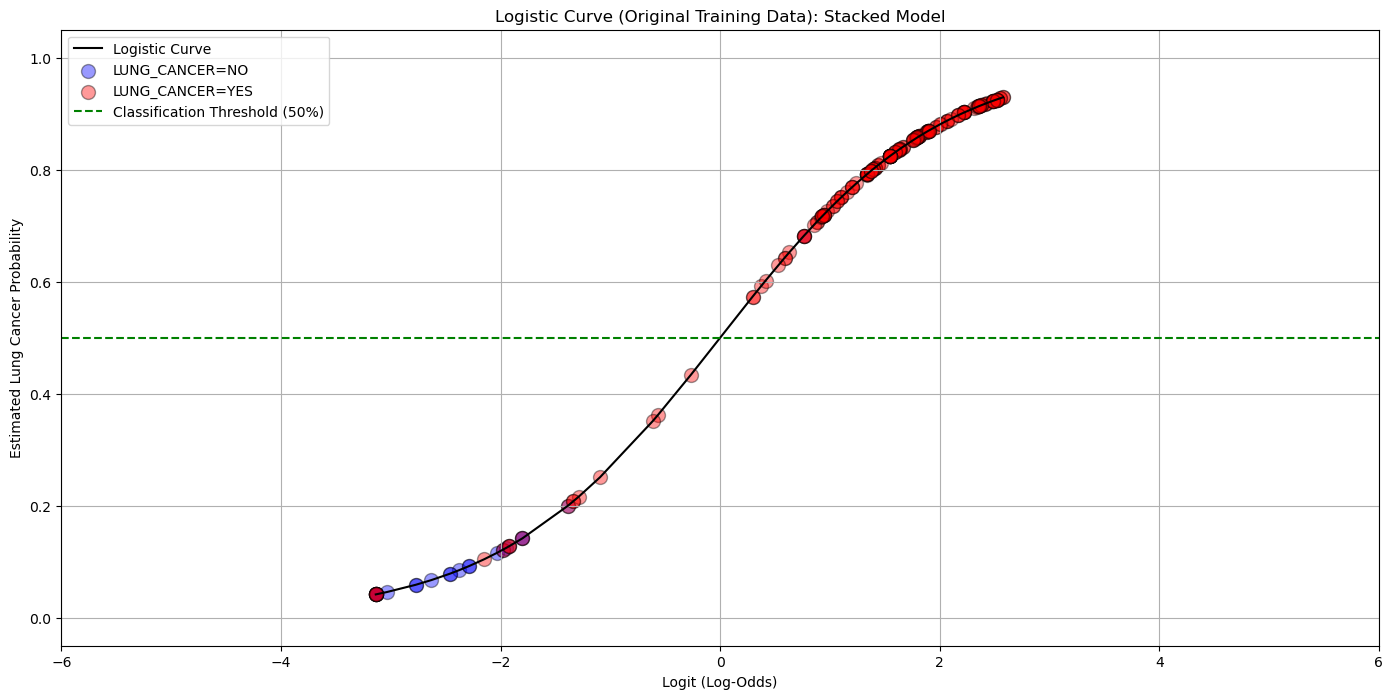

In [135]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(stacked_unbalanced_class_best_model_original_logit_values_sorted, 
         stacked_unbalanced_class_best_model_original_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-6.00, 6.00)
target_0_indices = y_train == 0
target_1_indices = y_train == 1
plt.scatter(stacked_unbalanced_class_best_model_original_logit_values[target_0_indices], 
            stacked_unbalanced_class_best_model_original_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(stacked_unbalanced_class_best_model_original_logit_values[target_1_indices], 
            stacked_unbalanced_class_best_model_original_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Original Training Data): Stacked Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [136]:
##################################
# Saving the best stacked model
# developed from the original training data
################################## 
joblib.dump(stacked_unbalanced_class_best_model_original, 
            os.path.join("..", MODELS_PATH, "stacked_unbalanced_class_best_model_original.pkl"))

['..\\models\\stacked_unbalanced_class_best_model_original.pkl']

### 1.6.5 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.5"></a>

#### 1.6.5.1 Individual Classifier <a class="anchor" id="1.6.5.1"></a>

#### 1.6.5.2 Stacked Classifier <a class="anchor" id="1.6.5.2"></a>

### 1.6.6 Model Fitting using Downsampled Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.5"></a>

#### 1.6.6.1 Individual Classifier <a class="anchor" id="1.6.6.1"></a>

#### 1.6.6.2 Stacked Classifier <a class="anchor" id="1.6.6.2"></a>

### 1.6.7 Model Selection <a class="anchor" id="1.6.7"></a>

### 1.6.8 Model Testing <a class="anchor" id="1.6.8"></a>

In [137]:
##################################
# Evaluating the F1 scores
# on the test data
##################################
individual_unbalanced_class_best_model_original_f1_test = f1_score(y_test, individual_unbalanced_class_best_model_original.predict(X_test))

In [138]:
##################################
# Summarizing the F1 score results
##################################
print(f"F1 Score of the Best Model (with Original Train Data) on Test Data: {individual_unbalanced_class_best_model_original_f1_test:.4f}")

F1 Score of the Best Model (with Original Train Data) on Test Data: 0.9200


### 1.6.9 Model Inference | Interpretation <a class="anchor" id="1.6.7"></a>

In [139]:
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 15px; font-family: 'Trebuchet MS'; }</style>"))